In [ ]:
import pandas as pd
from osgeo import gdal
from pyproj import CRS, Transformer
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np

Intro

# Cropping

In [ ]:
map_path = Path('../data/maps/raw_maps/')
gcp_path = Path('../data/gcps/raw/')
map_files = [f for f in os.listdir(map_path) if f.endswith('jpg')]

Scanned old maps look like this:

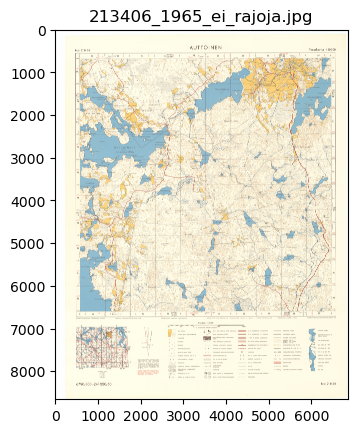

In [ ]:
ex_file = map_files[0]
ex_im = cv2.imread(str(map_path/ex_file))
ex_im = cv2.cvtColor(ex_im, cv2.COLOR_BGR2RGB)
plt.imshow(ex_im)
plt.title(ex_file)
plt.show()

And the corresponding ground control points (GCPs) are saved in this format:

In [ ]:
points = pd.read_csv(gcp_path/f'{ex_file}.points')
points.head()

,mapX,mapY,pixelX,pixelY,enable,dX,dY,residual
0,24.929733,61.305223,574,700,1,0,0,0
1,25.116309,61.303818,6454,684,1,0,0,0
2,25.113131,61.214096,6470,6589,1,0,0,0
3,24.927086,61.215496,587,6607,1,0,0,0


As the map images contain a lot of unnecessary data for our purposes, first thing we need to do is to crop images to contain only the relevant area, and adjust the GCPs accordingly. Save the resulting files so they can be used later.

In [ ]:
cropped_gcp_path = Path('../data/gcps/cropped/')
cropped_map_path = Path('../data/maps/cropped_maps/')
for m in map_files:
    im = cv2.imread(str(map_path/m))
    
    points = pd.read_csv(gcp_path/f'{m}.points')
    xmin = points.pixelX.min()
    xmax = points.pixelX.max()
    ymin = points.pixelY.min()
    ymax = points.pixelY.max()
    new_points = points.copy()
    new_points.loc[0, 'pixelX'] = max(0, new_points.iloc[0]['pixelX'] - xmin)
    new_points.loc[0, 'pixelY'] = max(0, new_points.iloc[0]['pixelY'] - ymin)
    new_points.loc[1, 'pixelX'] = min(xmax-xmin, new_points.iloc[1]['pixelX']-xmin)
    new_points.loc[1, 'pixelY'] = max(0, new_points.iloc[1]['pixelY'] - ymin)
    new_points.loc[2, 'pixelX'] = min(xmax-xmin, new_points.iloc[2]['pixelX']-xmin)
    new_points.loc[2, 'pixelY'] = min(ymax-ymin, new_points.iloc[2]['pixelY']-ymin)
    new_points.loc[3, 'pixelX'] = max(0, new_points.iloc[3]['pixelX'] - xmin)
    new_points.loc[3, 'pixelY'] = min(ymax-ymin, new_points.iloc[3]['pixelY']-ymin)
    new_points.to_csv(cropped_gcp_path/f'{m}.points', index=False)
    
    cropped_map = im[ymin:ymax, xmin:xmax]
    cv2.imwrite(str(cropped_map_path/m), cropped_map)

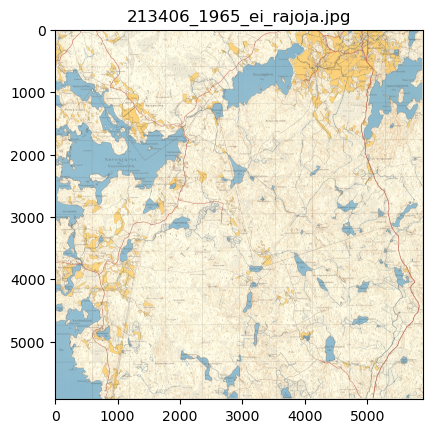

In [ ]:
cropped_ex = cv2.imread(str(cropped_map_path/ex_file))
cropped_ex = cv2.cvtColor(cropped_ex, cv2.COLOR_BGR2RGB)
plt.imshow(cropped_ex)
plt.title(ex_file)
plt.show()

In [ ]:
cropped_points = pd.read_csv(cropped_gcp_path/f'{ex_file}.points')
cropped_points.head()

,mapX,mapY,pixelX,pixelY,enable,dX,dY,residual
0,24.929733,61.305223,0,16,1,0,0,0
1,25.116309,61.303818,5880,0,1,0,0,0
2,25.113131,61.214096,5896,5905,1,0,0,0
3,24.927086,61.215496,13,5923,1,0,0,0


# Georeferencing

After cropping, the maps are aligned and converted to `EPSG:3067` coordinates, as it is closest to the original map CRS. GCPs are in `EPSG:4326`, so they need to be converted first.

In [ ]:
aligned_map_outpath = Path('../data/maps/aligned_maps/')

in_crs = CRS('EPSG:4326')
out_crs = CRS('EPSG:3067')
transformer = Transformer.from_crs(in_crs, out_crs, always_xy=True)

for m in map_files:
    gcp_list = []
    new_points = pd.read_csv(cropped_gcp_path/f'{m}.points')
    
    for row in new_points.itertuples():
        tfmd_x, tfmd_y = transformer.transform(row.mapX, row.mapY)
        gcp_list.append(gdal.GCP(tfmd_x, tfmd_y, 1, row.pixelX, row.pixelY))
        
    translate_kwargs = {
        'GCPs': gcp_list,
        'format': 'GTIFF',
        'bandList': [1,2,3]
    }
    
    out_fname = m.replace('jpg', 'tif')
    gdal.Translate(str(aligned_map_outpath/out_fname), str(cropped_map_path/m), **translate_kwargs)
    gdal.Warp(str(aligned_map_outpath/out_fname), str(aligned_map_outpath/out_fname),
              options='-r near -tps -co COMPRESS=LZW -t_srs EPSG:3067')

Final results are georeferenced RGB images in `EPSG:3067` coordinates.

In [ ]:
import rasterio as rio
import rasterio.plot as rioplot

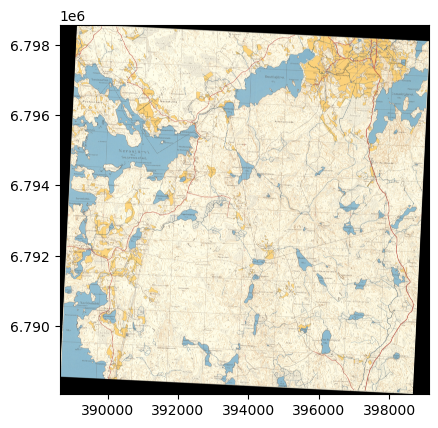

<AxesSubplot:>

In [ ]:
src = rio.open(aligned_map_outpath/ex_file.replace('jpg', 'tif'))
rioplot.show(src)